Criar um dataframe baseado nas movimentações dos lotes nas tarefas de depósitos

Informações importantes do dataframe:
    <p>lote
    <p>autor
    <p>dia da semana
    <p>hora do dia (manhã ou tarde)
    <p>origem
    <p>destino
    <p>item


Criar uma base com todas as UCs que já foram inventariadas por não terem sido encontradas

Criar mais arquivos de tarefas até o dia mais atual para ter mais dados

### Importando os dados criados pelo arquivo 'analise_tarefas.xlsx'

In [170]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [171]:
tarefas = pd.read_csv('dados/Tarefas/tarefas_concat.csv', dtype = {'uc':'string'})

# Criando a coluna com as iniciais dos autores para desconsiderar o que não é da P3
tarefas['inicial_autor'] = tarefas['autor'].str[:3]
tarefas.head()

,tipo_processo,autor,data_criacao,hora_criacao,pd_origem,pd_destino,produto,tipo_estoque,desc_tipo_estoque,uc,dia_semana,nome_dia_semana,inicial_autor
0,Transferência interna de estoque,SP3EMBA01,2022-01-31,23:57:38,GR-PROD,GR-PROD,SA0579,Estoque QA 005,03,112345673000001352,0,seg,SP3
1,Transferência interna de estoque,SP3LLJUNIOR,2022-01-31,23:57:27,NaN,CHECKPOINT 1,NaN,NaN,NaN,20002214,0,seg,SP3
2,Transferência interna de estoque,SP3PROD04,2022-01-31,23:57:18,GR-PROD,GR-PROD,SA0309,Estoque QA 005,03,112345673000001351,0,seg,SP3
3,Transferência interna de estoque,SP3DSSILVA,2022-01-31,23:56:18,NaN,CHECKPOINT 2,NaN,NaN,NaN,20002147,0,seg,SP3
4,Transferência interna de estoque,SP3DSSILVA,2022-01-31,23:54:40,NaN,CHECKPOINT 2,NaN,NaN,NaN,20002213,0,seg,SP3


In [172]:
tarefas['inicial_autor'].unique()

array(['SP3', 'JOB', 'MG1', 'SP2', 'GHS', 'DAP', 'BA1', 'LPO', 'MG5',
       'TSP', 'FWO', 'AM2'], dtype=object)

In [173]:
tarefas.shape

(660102, 13)

#### Cria um dataframe apenas com as UCs que foram inventariadas

In [174]:
# Cria a base de todas as tarefas com tipo inventário
base_ucs_inventario = tarefas.query('tipo_processo == "Inventário"')

# Cria um dataframe com apenas as UCs que foram inventariadas
ucs_inventariadas = base_ucs_inventario['uc'].unique()
ucs_inventariadas
ucs_inventariadas = pd.DataFrame(ucs_inventariadas)
ucs_inventariadas.rename(columns={0:'uc'}, inplace=True)
ucs_inventariadas['inventariado'] = 1
ucs_inventariadas.head()

,uc,inventariado
0,3308727,1
1,3328327,1
2,3141733,1
3,3298658,1
4,3349245,1


### Tratando o dataframe para eliminar as informações desnecessárias

In [175]:
# Limpando os dados nulos das colunas 'UC' e 'PD_ORIGEM'
tarefas_dropna = tarefas.dropna(subset=['uc','pd_origem'])

# Refazendo o dataframe considerando apenas os autores 'SP3' e 'JOB...'
tarefas_dropna = tarefas_dropna.query('inicial_autor == "SP3" or inicial_autor == "JOB"')
tarefas_dropna = tarefas_dropna.query('autor != "SP3MHLEITE" and autor != "SP3VLALMEIDA"')

tarefas_dropna.head()

,tipo_processo,autor,data_criacao,hora_criacao,pd_origem,pd_destino,produto,tipo_estoque,desc_tipo_estoque,uc,dia_semana,nome_dia_semana,inicial_autor
0,Transferência interna de estoque,SP3EMBA01,2022-01-31,23:57:38,GR-PROD,GR-PROD,SA0579,Estoque QA 005,03,112345673000001352,0,seg,SP3
2,Transferência interna de estoque,SP3PROD04,2022-01-31,23:57:18,GR-PROD,GR-PROD,SA0309,Estoque QA 005,03,112345673000001351,0,seg,SP3
5,Transferência interna de estoque,SP3EMBA01,2022-01-31,23:54:26,GR-PROD,GR-PROD,SA0209,Estoque QA 005,03,112345673000001345,0,seg,SP3
11,Transferência interna de estoque,SP3EMBA01,2022-01-31,23:51:28,GR-PROD,GR-PROD,SA0309,Estoque QA 005,03,112345673000001350,0,seg,SP3
12,Saída de depósito,SP3DSSILVA,2022-01-31,23:51:22,ESTOR,GI-YDO1,SA0309,Estoque utilização livre 005,01,112345678000372283,0,seg,SP3


In [176]:
tarefas_dropna.shape

(234772, 13)

#### Exibindo a quantidade de registros de cada tipo

In [177]:
qtd_ucs = tarefas_dropna['uc'].unique().shape[0]
qtd_autor = tarefas_dropna['autor'].unique().shape[0]
qtd_tipo_processo = tarefas_dropna['tipo_processo'].unique().shape[0]
qtd_dia_semana = tarefas_dropna['dia_semana'].unique().shape[0]

print('Qtd de registro de UCs: ', qtd_ucs)
print('Qtd de autores: ', qtd_autor)
print('Qtd de tipo de processo: ', qtd_tipo_processo)
print('Qtd de dia semana: ', qtd_dia_semana)

Qtd de registro de UCs:  75842
Qtd de autores:  81
Qtd de tipo de processo:  3
Qtd de dia semana:  7


In [178]:
tarefas_dropna['tipo_processo'].unique()

array(['Transferência interna de estoque', 'Saída de depósito',
       'Entrada em depósito'], dtype=object)

In [179]:
tarefas_dropna.shape

(234772, 13)

#### Criando o dataframe que servirá se base para o 'get.dummies'

In [180]:
# Cria o df com as variáveis de interesse
df_tarefas = tarefas_dropna[['uc', 'tipo_processo', 'autor', 'nome_dia_semana']]

# Une os df de itens inventariados com o geral de tarefas
df_tarefas = df_tarefas.merge(ucs_inventariadas, left_on='uc', right_on='uc', how="outer")

# Altera os valores 'NaN' da coluna inventariado para 0 e depois mapeia os valores para transformar em 'sim' e 'nao'
df_tarefas['inventariado'] = df_tarefas['inventariado'].fillna(0)

df_tarefas.drop(columns=['uc'], inplace=True)

df_tarefas.dropna(inplace=True)

df_tarefas.head()

,tipo_processo,autor,nome_dia_semana,inventariado
0,Transferência interna de estoque,SP3EMBA01,seg,0.0
1,Saída de depósito,SP3PRAZEVEDO,seg,0.0
2,Transferência interna de estoque,SP3ASSILVA,ter,0.0
3,Transferência interna de estoque,SP3ALFONSECA,ter,0.0
4,Transferência interna de estoque,SP3PROD04,seg,0.0


In [181]:
df_tarefas.shape

(234772, 4)

In [182]:
df_tarefas['inventariado'].unique()

array([0., 1.])

#### Criando o dataframe com 'get_dummies'

In [183]:
# Criando o dataframe X
x = df_tarefas.drop(columns=['inventariado'], axis=1)
x.head()

,tipo_processo,autor,nome_dia_semana
0,Transferência interna de estoque,SP3EMBA01,seg
1,Saída de depósito,SP3PRAZEVEDO,seg
2,Transferência interna de estoque,SP3ASSILVA,ter
3,Transferência interna de estoque,SP3ALFONSECA,ter
4,Transferência interna de estoque,SP3PROD04,seg


In [184]:
# Criando o dataframe Y
y = df_tarefas['inventariado']
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: inventariado, dtype: float64

In [185]:
x_dummies = pd.get_dummies(x)
x_dummies.head()

,tipo_processo_Entrada em depósito,tipo_processo_Saída de depósito,tipo_processo_Transferência interna de estoque,autor_JOBSCHEDULER,autor_SP3AAFERREIR,autor_SP3AECOELHO,autor_SP3AFNETO,autor_SP3AFSILVA,autor_SP3AFSILVA1,autor_SP3AHSERRA,...,autor_SP3WGJUNIOR,autor_SP3WJJUNIOR,autor_SP3WRCONCEIÇ,nome_dia_semana_dom,nome_dia_semana_qua,nome_dia_semana_qui,nome_dia_semana_sab,nome_dia_semana_seg,nome_dia_semana_sex,nome_dia_semana_ter
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [186]:
x_dummies.shape

(234772, 91)

### Treinando o modelo

In [187]:
# Criando as divisões de teste e treino

treino_x, teste_x, treino_y, teste_y = train_test_split(x_dummies, y, test_size=0.30, random_state=10)

print('Tamanho "treino_x": ', len(treino_x))
print('Tamanho "teste_x": ', len(teste_x))
print('Tamanho "treino_y": ', len(treino_y))
print('Tamanho "teste_x": ', len(teste_x))

Tamanho "treino_x":  164340
Tamanho "teste_x":  70432
Tamanho "treino_y":  164340
Tamanho "teste_x":  70432


In [188]:
treino_x.shape

(164340, 91)

#### Criando a previsão base

In [189]:
previsao_base = np.ones(len(teste_x))

In [190]:
# Verificando a precisão do modelo base

precisao = (accuracy_score(teste_y, previsao_base))* 100

print('Precisão do modelo: ', precisao)

Precisão do modelo:  0.7894139027714676


#### Adaboost

In [191]:
# Criando e treinando o modelo
modelo_ada = AdaBoostClassifier()
modelo_ada.fit(treino_x, treino_y)


AdaBoostClassifier()

In [192]:
# Previsão
previsao_ada = modelo_ada.predict(teste_x)

# Verificando a precisão do modelo
precisao_ada = (accuracy_score(teste_y, previsao_ada))* 100

print('Precisão do modelo: ', precisao_ada)

Precisão do modelo:  99.21058609722854


#### Árvore de decisão

In [193]:
# Criando e treinando o modelo
modelo_arvore = DecisionTreeClassifier(max_depth=5)
modelo_arvore.fit(treino_x, treino_y)

DecisionTreeClassifier(max_depth=5)

In [194]:
# Previsão
previsao_arvore = modelo_arvore.predict(teste_x)

# Verificando a precisão do modelo
precisao_arvore = (accuracy_score(teste_y, previsao_arvore))*100

print('Precisão do modelo: ', precisao_arvore)

Precisão do modelo:  99.21200590640618


#### Exibindo graficamente a árvore de decisão

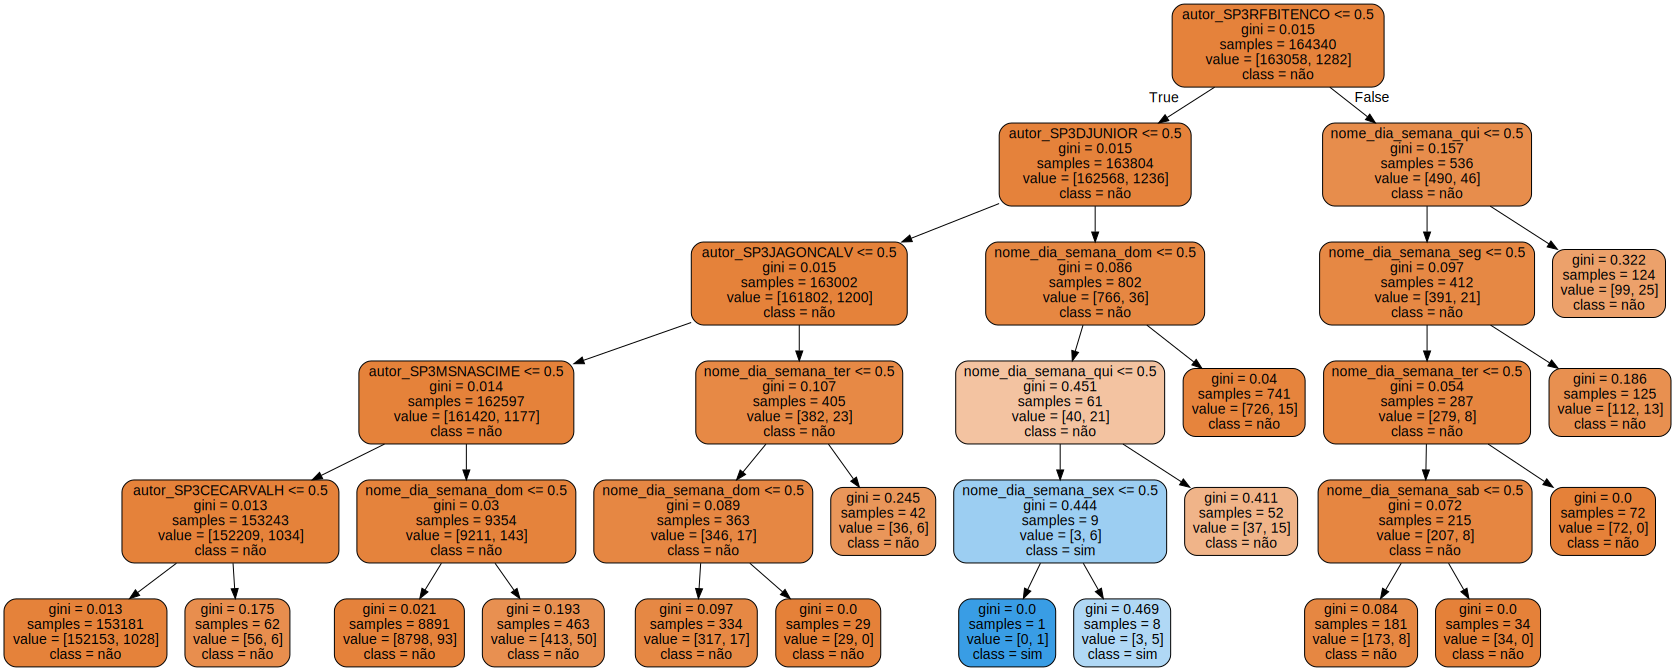

In [195]:
features = x_dummies.columns

dados_grafico = export_graphviz(modelo_arvore,
                                out_file=None,
                                filled=True,
                                rounded=True,
                                feature_names=features,
                                class_names=['não','sim']
                                )

grafico = graphviz.Source(dados_grafico)
grafico

### Testando em 1 registro